<a href="https://colab.research.google.com/github/hermmanhender/curso-control-optimo-UTNFRLR/blob/main/Actividades/Control_motor_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad 1: Control de un motor de CC

Se propone controlar un motor CC que tiene que mantener una velocidad constante, para lo cual se implementó un controlador PID y se emplearon tres ternas de parámetros. 

En este ejemplo se crea una tabla de valores y se utiliza para realizar el control de un motor de CC. Los resultados del control son guardados en una grafica que se puede visualizar al final del código.

## Integración usando Euler en un Motor CC
Se tiene un modelo de un motor de corriente continua con un torque de carga en el rotor, como muestra la Fig. 1-5.

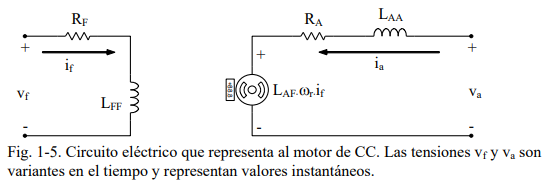

Las especificaciones son los parámetros que se muestran en la Fig. 1-5. y las variables de interés del motor se relacionan según las Ec (21), (22) y (23).

Las variables de interés en el motor de CC son $i_{a}$, $i_{f}$, y $\omega_{r}$. Las ecuaciones que las relacionan dinámicamente son:

$\frac{di_{f}}{dt} = -\frac{R_{F}}{L_{FF}} i_{f} + \frac{1}{L_{FF}} v_{f}$ (21)

$\frac{di_{a}}{dt} = -\frac{R_{A}}{L_{AA}} i_{a} - \frac{L_{AF}}{L_{AA}} i_{f} ω_{r} + \frac{1}{L_{AA}} v_{a}$ (22)

$\frac{dω_{r}}{dt} = -\frac{B_{m}}{J} ω_{r} + \frac{L_{AF}}{J} i_{f} i_{a} -\frac{1}{J} T_{L}$ (23)

donde $J$ es la inercia del rotor, $B_{m}$ es el amortiguamiento, y $T_{L}$ es el torque de la carga.
Se puede simplificar cuando la corriente de magnetización $i_{f}$ es constante.

Entonces se tiene:
$K_{i} = \frac{L_{AF}}{J} i_{f}$ (24)

$T_{m} = K_{i} i_{a}$

$\frac{di_{a}}{dt} = -\frac{R_{A}}{L_{AA}} i_{a} - \frac{K_{m}}{L_{AA}} ω_{r} + \frac{1}{L_{AA}} v_{a}$ (25)

$\frac{dω_{r}}{dt} = -\frac{K_{i}}{J} i_{a} + \frac{B_{m}}{J} ω_{r} -\frac{1}{J} T_{L}$ (26)

De donde la función de transferencia es:

$\frac{ω_{r}(s)}{v_{a}(s)} = \frac{5.57 * 10^9}{s^2 + 1.52*10^5 s + 2.31*10^7}$

Nótese que los polos son $\lambda_{1} = -1,5185*10^5
, \lambda_{2} = -152,1259$. Aquí se puede encontrar el
tiempo al que corresponde el 95% de la dinámica más rápida $exp(\lambda_{1}t)$ es:

$t_{R}=\frac{ln(0.95)}{\lambda_{1}}$ (30)

de donde se selecciona el tiempo de integración menor que ése $t_{R}$ calculado, por ejemplo, tres veces menor.

Luego, para calcular el tiempo de simulación en el cual prácticamente ya no hay más transitorios, se toma la constante de tiempo más lenta y se calcula el tiempo para que la $exp(\lambda_{2}t)$ llegue al $5%$, ése tiempo sería

$t_{L} = \frac{ln(0.05)}{\lambda_{2}}$ (31)

Se puede tomar por ejemplo, el triple de ése valor $t_{L}$.

En lo siguiente se detalla el código para simular el desarrollo de las variables de estado con la respuesta al escalón, es decir, $\omega_{Ref} = 1$. En la Tabla 1-2 está el detalle del modelo lineal del motor CC.

### Paso 1:
Se importan las librerías necesarias para trabajar con los programas que se desarrollarán.

In [66]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

### Paso 2:
Se escribe el código lineal para la simulación del motor de corriente continua.

In [67]:
def modmotor(t_etapa, xant, accion):
  """
  Modelo del sistema lineal del motor de CC
  """
  Laa=366e-6 # Inductancia del motor
  J=5e-9 # Inercia del rotor del motor
  Ra=55.6 # Resistencia del motor
  B=0 # Amortiguamiento
  Ki=6.49e-3 # Constante proporcional del motor ???
  Km=6.53e-3 # Constante integral del motor ???
  Va=accion # Tensión de la carga del motor ???
  h=1e-7 # Paso de tiempo para la discretización ???
  omega= xant[0] # Velocidad de rotación del motor
  wp= xant[1] # ????

  for ii in range(1,int(t_etapa/h)):
    wpp =(-wp*(Ra*J+Laa*B)-omega*(Ra*B+Ki*Km)+Va*Ki)/(J*Laa)
    wp += h*wpp
    omega += h*wp

  return [omega,wp]

### Paso 3:
Código de integración de Euler para el sistema lineal del motor de CC con PID

In [68]:
from numpy.core.fromnumeric import take
def euler_PID(X=[0, 0], # X_0 = [omega, wp]
              ii=0, 
              t_etapa=1e-7, 
              wRef=2, 
              tF=.001, 
              Kp=.500, 
              Ki=0.001, 
              Kd=0.00001):
  """
  Código de integración de Euler para el sistema lineal del motor de CC con PID
  """  
  # Se establece el tiempo inicial a evaluar
  Ts = t_etapa

  # Se calculan los componentes de la ecuación del controlador PID en
  # tiempo discreto
  A1=((2*Kp*Ts)+(Ki*(Ts**2))+(2*Kd))/(2*Ts)
  B1=(-2*Kp*Ts+Ki*(Ts**2)-4*Kd)/(2*Ts)
  C1=Kd/Ts

  # Se genera una vector que contiene una cantidad de elementos igual a
  # los pasos de tiempo que se ejecutaran. Aquí se almacenaran los 
  # errores encontrados para poder luego graficarlos.
  e = []
  for t in range(0, int(tF/t_etapa)):
    e.append(0)

  # Se crean listas para almacenar las variables calculadas
  x1 = [] # Para almacenar a omega
  x2 = [] # Para almacenar a wp
  acc = []
  # Se establece el valor del control PID en cero.
  u=0

  # Se ejecutan los t pasos de tiempo para calcular el error
  for t in range(0,int(tF/t_etapa)-2):
    k = t + 2
    X = modmotor(t_etapa, X, u) # X = [omega, wp]
    e[t] = wRef-X[0] # ERROR
    u += A1*e[k] + B1*e[k-1]+C1*e[k-2] # PID
    x1.append(X[0]) # Omega
    x2.append(X[1]) # wp
    acc.append(u)

  # Se grafican los resultados con Matplotlib  
  # data
  tiempo = []
  for t in range(0,int(tF/t_etapa)-2):
    tiempo.append(t)

  # plot de la tensión
  fig, (ax1, ax2) = plt.subplots(2, 1)

  ax1.plot(tiempo, x2, label="wp")
  ax1.plot(tiempo, acc, label="acc")
  ax2.plot(tiempo, x1, label="omega")

  ax1.set_xlabel('Tiempo, s')  # Add an x-label to the axes.
  ax1.set_ylabel('Tensión, V')  # Add a y-label to the axes.

  ax2.set_xlabel('Tiempo, s')  # Add an x-label to the axes.
  ax2.set_ylabel('velocidad, 1/rad')  # Add a y-label to the axes.
  
  ax1.legend();  # Add a legend.
  ax2.legend();  # Add a legend.

  plt.show()

### Paso 4:
Se simula el programa con diferentes configuraciones y se grafican los resultados obtenidos.

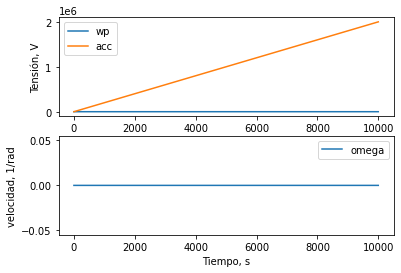

In [69]:
# Se establecen las variables a simular
t_etapa=1e-7
wRef=2
tF=0.001
Kp=0.500
Ki=0.001
Kd=0.00001

euler_PID(t_etapa=t_etapa, wRef=wRef, tF=tF, Kp=Kp, Ki=Ki, Kd=Kd)

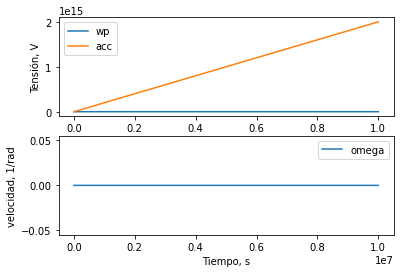

In [65]:
# Se establecen las variables a simular
t_etapa=1e-7
wRef=2
tF=1
Kp=1
Ki=1
Kd=10

euler_PID(t_etapa=t_etapa, wRef=wRef, tF=tF, Kp=Kp, Ki=Ki, Kd=Kd)